# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교

### 학습결과 시각화 함수 정의

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
def plot_result(hist, loss_min = None, loss_max = None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.epoch, hist.history['loss'], label = 'Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label = 'Validation Loss')
    plt.title('Loss')
    if loss_min != None and loss_max != None:
        plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## MNIST CNN 적용
### data loading

In [3]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

### 전처리, Dataset 생성
- X
    - uint8을 float32 타입으로 변경
    - pixcel값 정규화: 0 ~ 1
    - Gray scale에 channel 축이 없는 경우 dummy 축을 늘려준다
        - 영상처리 convolution layer(Conv2D)는 입력으로 3차원 (height, width, channel)배열을 받는다
- y: onehot encoding

In [4]:
# input 전처리
X_train = train_image.astype('float32')/255
X_train = X_train[..., np.newaxis]

X_test = test_image.astype('float32')/255
X_test = X_test[..., np.newaxis]

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)

float32 float32
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
# output 전처리 -> OneHot Encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

print(train_label.shape, y_train.shape)
print(test_label.shape, y_test.shape)

(60000,) (60000, 10)
(10000,) (10000, 10)


### 하이퍼파라미터 변수 설정

In [6]:
LEARNING_RATE = 0.001
N_EPOCH = 20
N_BATCH = 1000

N_TRAIN = X_train.shape[0]

### Dataset 생성

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

### Model(Network) 정의
- Feature Extraction(backbone): Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width)는 줄이고 channel은 늘리는 방향으로 Layer을 쌓는다
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
        - 위와 같이 지정해 input의 size를 절반으로 줄임
- 분류기
    - Dense Layer 사용
    - Flatten을 먼저 해야함(Conv의 output-feature map - 3차원 배열)

In [8]:
def get_mnist_cnn_model(lr = 0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(28, 28, 1)))

    # Feature Extractor -> Convolution Block (Conv + Maxpool)
    model.add(layers.Conv2D(filters = 16,
                            kernel_size=(3, 3),
                            strides = (1, 1),
                            padding = 'same',
                            activation = 'relu'))
    # MaxPooling Layer를 이용해 Feature map의 size를 줄임
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  strides=(2, 2),
                                  padding='same'))
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Flatten())
    # Dense Layer 추가
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=256, activation='relu'))
    # 출력
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))

    # 컴파일
    model.compile(optimizer = keras.optimizers.Adam(lr), loss = 'categorical_crossentropy', metrics=['accuracy'])

    return model

### 모델 생성 및 확인

In [9]:
model = get_mnist_cnn_model(LEARNING_RATE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

In [10]:
hist = model.fit(train_dataset, epochs=N_EPOCH, validation_data = test_dataset)

Epoch 1/20
60/60 [==============================] - 8s 18ms/step - loss: 0.8310 - accuracy: 0.7411 - val_loss: 0.1649 - val_accuracy: 0.9484
Epoch 2/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1733 - accuracy: 0.9460 - val_loss: 0.0926 - val_accuracy: 0.9719
Epoch 3/20
60/60 [==============================] - 1s 14ms/step - loss: 0.1154 - accuracy: 0.9649 - val_loss: 0.0623 - val_accuracy: 0.9800
Epoch 4/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0936 - accuracy: 0.9699 - val_loss: 0.0505 - val_accuracy: 0.9831
Epoch 5/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0783 - accuracy: 0.9754 - val_loss: 0.0434 - val_accuracy: 0.9854
Epoch 6/20
60/60 [==============================] - 1s 15ms/step - loss: 0.0673 - accuracy: 0.9789 - val_loss: 0.0368 - val_accuracy: 0.9879
Epoch 7/20
60/60 [==============================] - 1s 14ms/step - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.0342 - val_accuracy: 0.9884
Epoch 8/20
60

### 결과 시각화

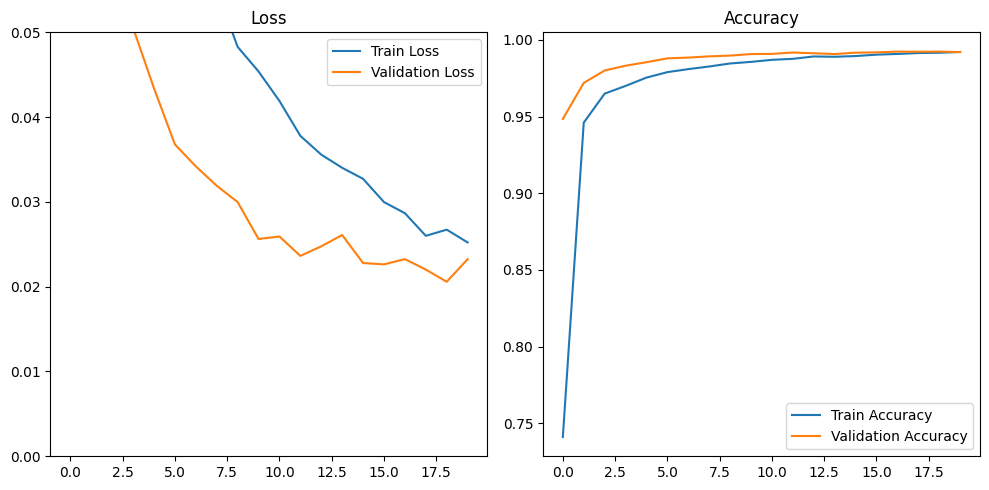

In [11]:
plot_result(hist, 0, 0.05)

### 최종검증

In [12]:
loss, acc = model.evaluate(test_dataset)
print(loss, acc)

10/10 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9920
0.023247355595231056 0.9919999837875366


### prediction error가 발생한 data 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인

In [13]:
X_test.shape

(10000, 28, 28, 1)

In [14]:
pred = model.predict(X_test)
pred.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [15]:
label = np.argmax(pred, axis=-1)
print(label.shape)
label[:5]

(10000,)


array([7, 2, 1, 0, 4])

In [16]:
# 모델이 추론한 결과중 정답과 다른 것의 index를 조회
fail_idx = np.where(test_label != label)[0]
fail_idx.size

80

### confusion matrix 확인

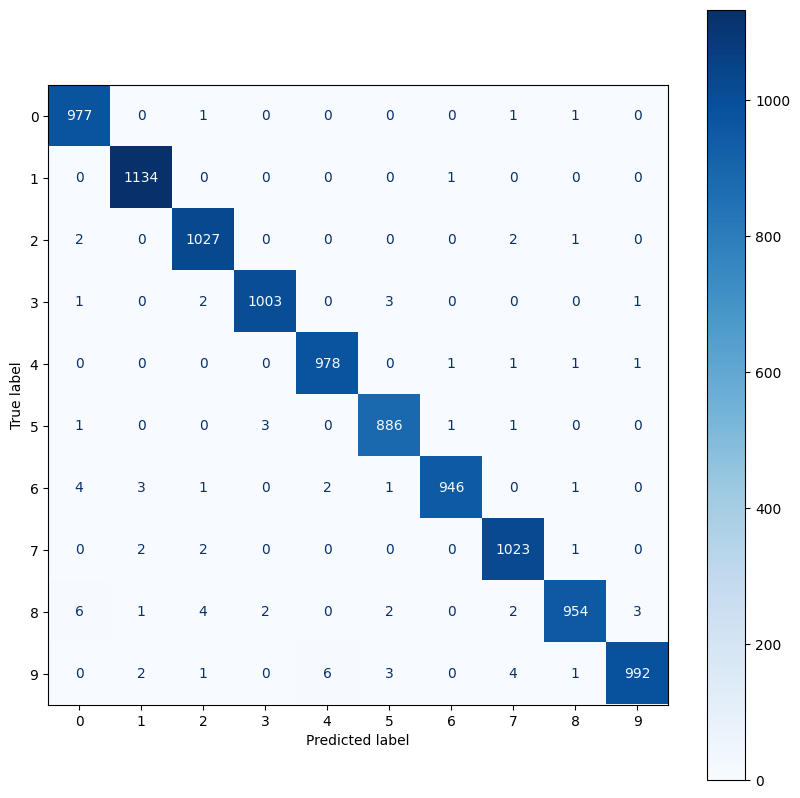

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10, 10))
ax = plt.gca()

cm = confusion_matrix(test_label, label)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='Blues', ax = ax)
plt.show()

8


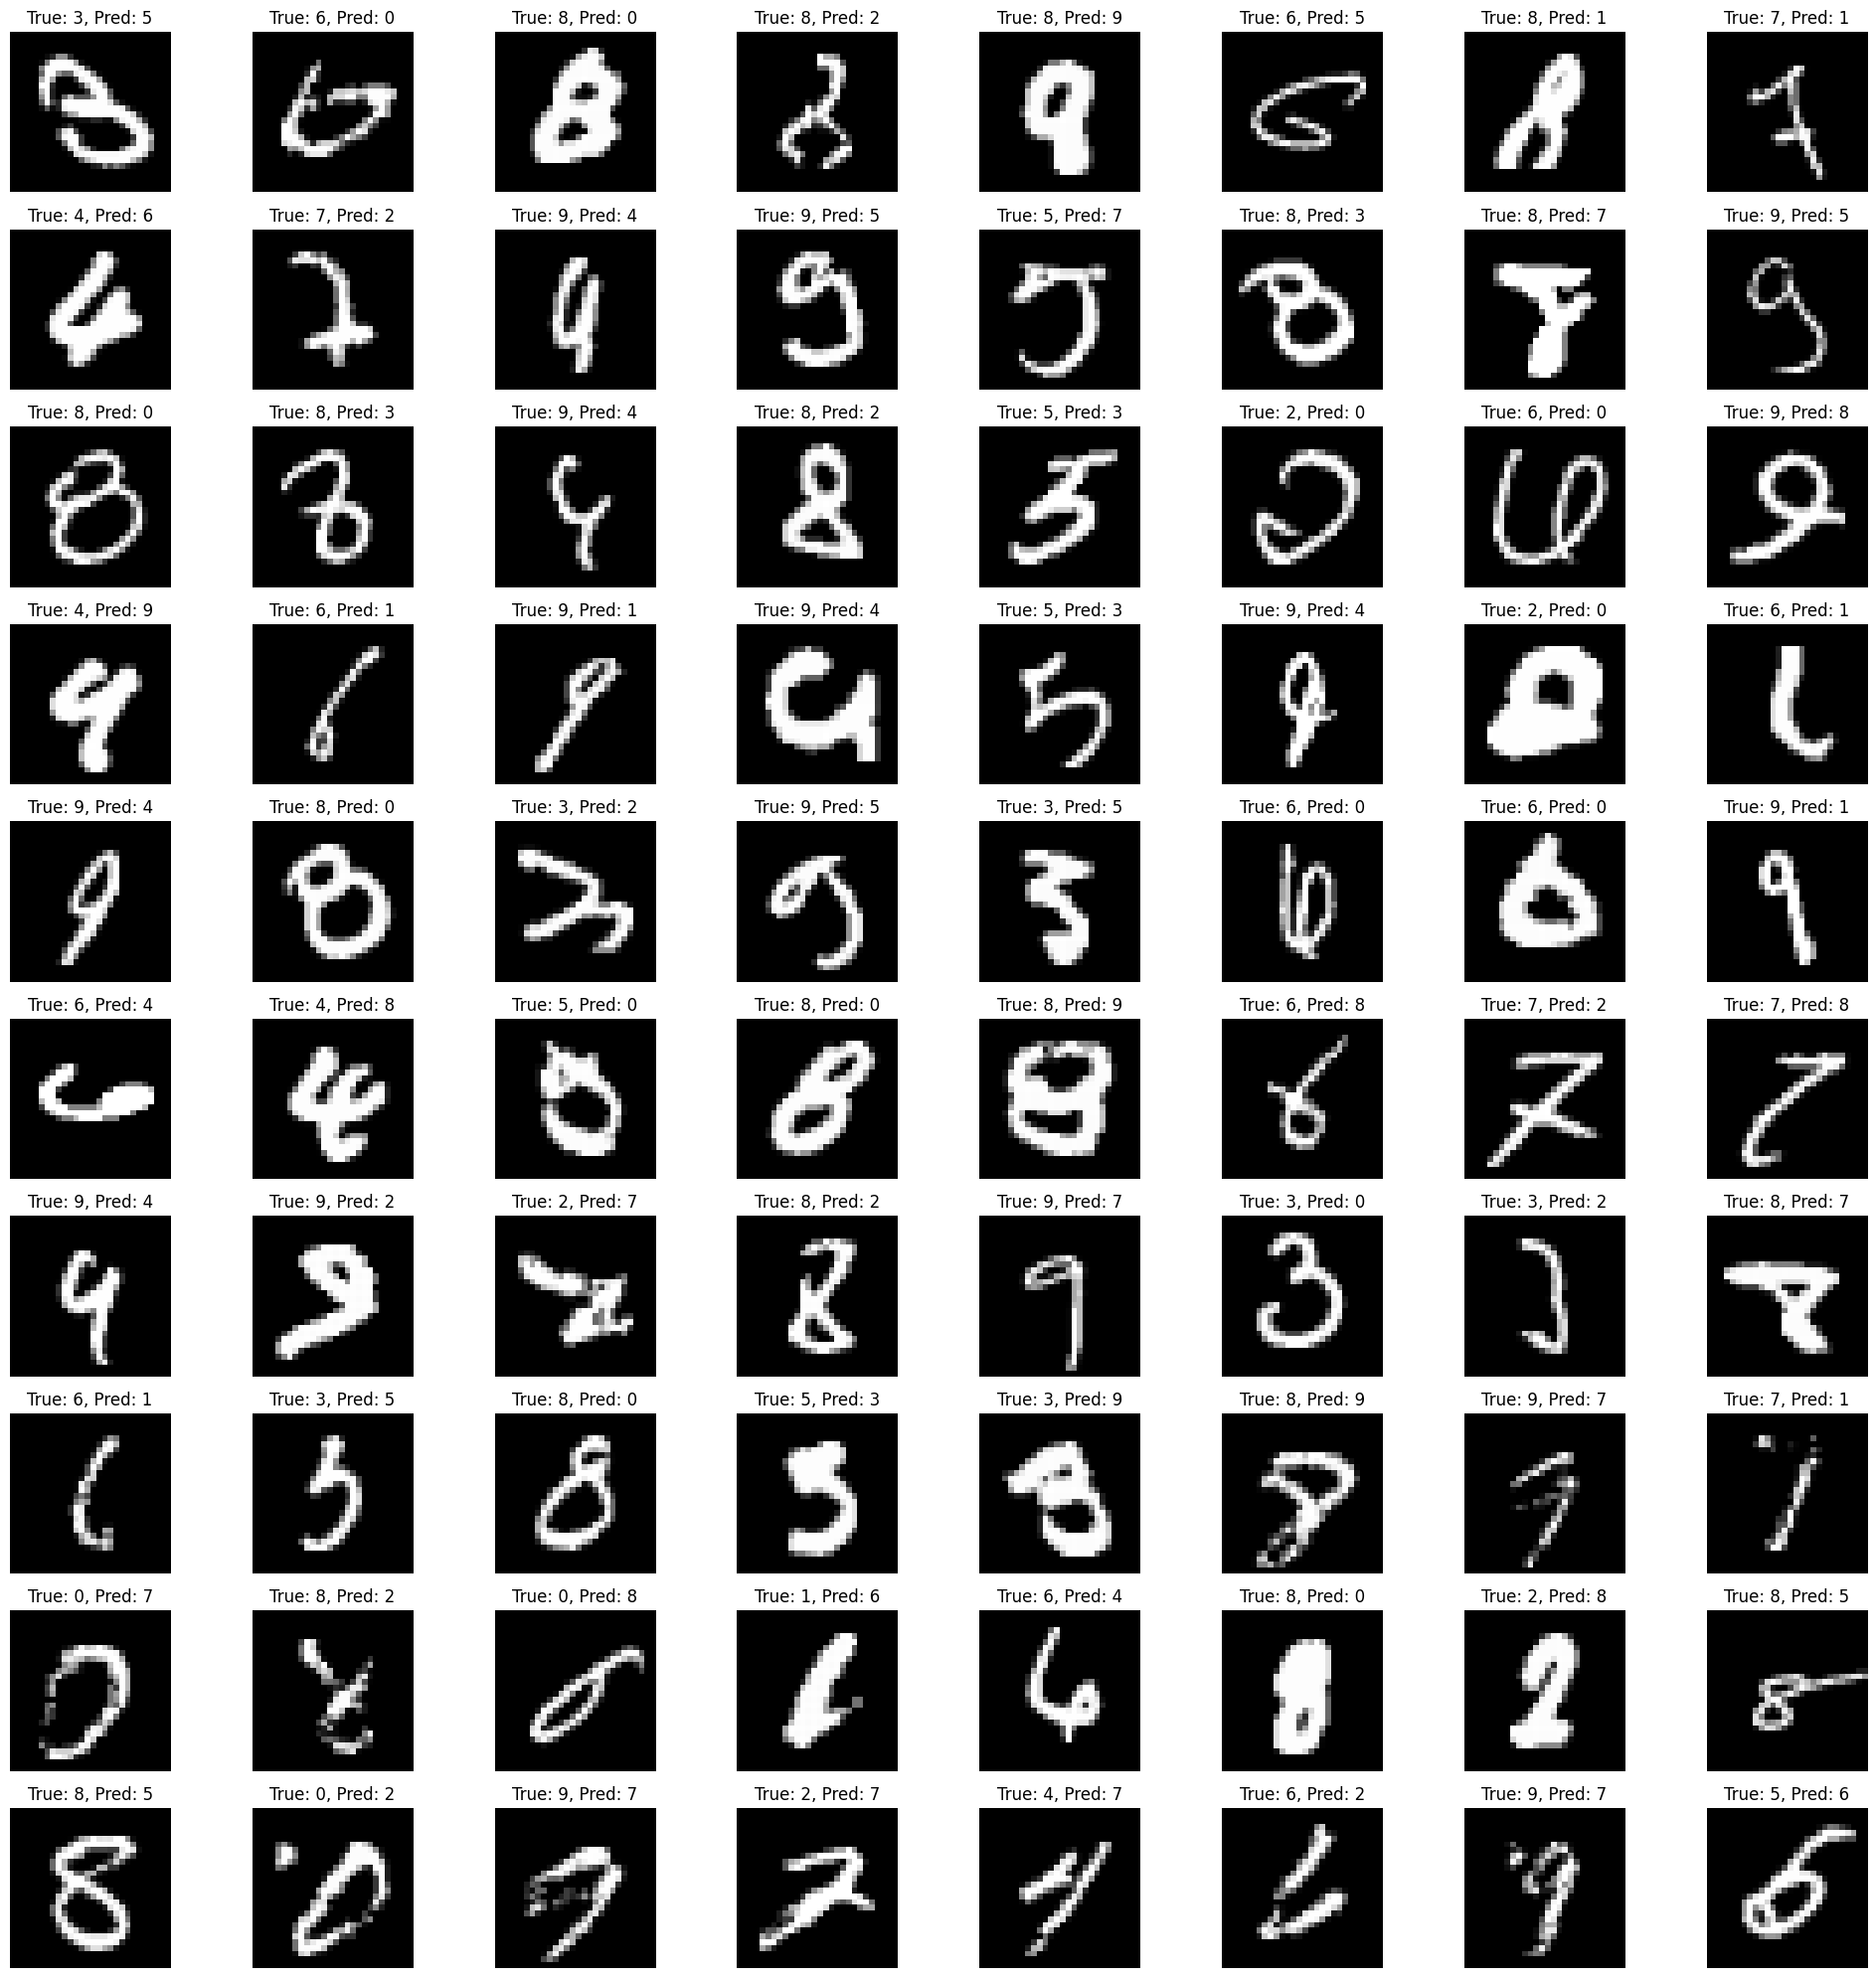

In [19]:
# 틀린 이미지 출력
plt.figure(figsize = (20, 20))
rows = int(np.ceil(fail_idx.size/10))
print(rows)

for i in range(int(fail_idx.size)):
    error_idx = fail_idx[i]
    pred_label = label[error_idx]
    true_label = test_label[error_idx]
    img = test_image[error_idx]

    plt.subplot(10, rows, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
fail_idx

array([  18,  445,  495,  582,  947, 1014, 1033, 1039, 1112, 1226, 1232,
       1247, 1299, 1319, 1530, 1709, 1717, 1878, 1901, 1955, 2035, 2098,
       2118, 2129, 2130, 2135, 2189, 2293, 2369, 2414, 2462, 2654, 2760,
       2896, 2927, 2939, 2953, 3030, 3422, 3503, 3520, 3534, 3558, 3662,
       3727, 3762, 3767, 3808, 3985, 4078, 4176, 4207, 4224, 4256, 4443,
       4497, 4699, 4740, 4807, 5937, 5955, 6555, 6571, 6576, 6597, 6625,
       6651, 6783, 6847, 8065, 8094, 8408, 9280, 9634, 9642, 9664, 9669,
       9679, 9692, 9729])

In [21]:
path = '/content/drive/MyDrive/github/mnist_cnn'
model.save(path)

In [22]:
path = '/content/drive/MyDrive/github/mnist_cnn'
saved_model = models.load_model(path)

In [23]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

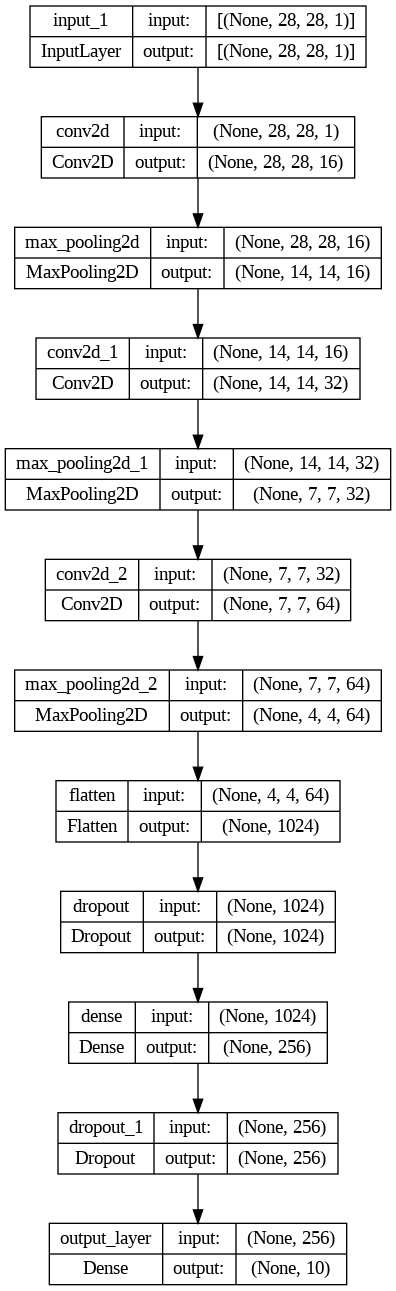

In [24]:
keras.utils.plot_model(saved_model, show_shapes = True)

In [25]:
saved_model.evaluate(test_dataset)

10/10 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9920


[0.023247355595231056, 0.9919999837875366]

### 학습한 모델 파일로 저장
- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    2. 모델 구조와 파라미터 모두 저장
- **저장시점**
    1. Train 완료된 모델을 저장
    2. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

### 텐서플로 저장 파일 타입
- checkpoint
    - 모델의 weight를 저장하기 위한 타입
- SavedModel
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

### 학습한 Weight(파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다
- 저장
    - model.save_weights("저장경로")
- 불러오기
    - model.load_weight("불러올 경로")
- 저장형식
    - Tensorflow Checkpoint(기본방식)
    - HDFS
        - save_weight(..., save_format='h5')
        - 또는 파일 확장자를 h5로 지정

In [26]:
# 저장할 디렉토리 생성
import os
SAVE_ROOT_PATH = '/content/drive/MyDrive/github'
SAVE_MODEL_PATH = os.path.join(SAVE_ROOT_PATH, 'saved_models')
os.makedirs(SAVE_MODEL_PATH, exist_ok = True)
print(os.path.isdir(SAVE_MODEL_PATH))

True


In [29]:
# MODEL의 파라미터들만 저장 -> model.save_weight(저장파일경로)
MNIST_WEIGHTS_DIR_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_cnn_weights')
os.makedirs(MNIST_WEIGHTS_DIR_PATH, exist_ok = True)
MNIST_WEIGHTS_FILE_PATH = os.path.join(MNIST_WEIGHTS_DIR_PATH, 'ckpt')


In [30]:
saved_model.save_weights(MNIST_WEIGHTS_FILE_PATH)

In [31]:
# 저장된 WEIGHT를 LOADING해서 모델을 RESTORE
# 1. 모델을 생성
saved_model2 = get_mnist_cnn_model(LEARNING_RATE)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 1s 12ms/step - loss: 2.3052 - accuracy: 0.0748


[2.305156946182251, 0.07479999959468842]

In [32]:
# 2. 생성한 모델에 weight를 덮어씌운다
saved_model2.load_weights(MNIST_WEIGHTS_FILE_PATH)
saved_model2.evaluate(test_dataset)

10/10 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9920


[0.023247355595231056, 0.9919999837875366]

### 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow **SavedModel** 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')`
        - 또는 파일의 확장자를 h5로 지정한다.

In [33]:
MNIST_MODEL_PATH = os.path.join(SAVE_MODEL_PATH, 'mnist_model')

In [34]:
saved_model.save(MNIST_MODEL_PATH)

In [35]:
saved_model3 = tf.keras.models.load_model(MNIST_MODEL_PATH)
saved_model3.evaluate(test_dataset)

10/10 [==============================] - 0s 11ms/step - loss: 0.0232 - accuracy: 0.9920


[0.023247355595231056, 0.9919999837875366]

### Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- #### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다.
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- #### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다.

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [36]:
# 모델생성
model2 = get_mnist_cnn_model(LEARNING_RATE)

In [37]:
# CALLBACK
# MNIST_MODEL_CALLBACK_{epoch:04d}
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_MODEL_CALLBACK')
mc_callback = keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH,
                                              save_best_only = True,
                                              monitor = 'val_loss',
                                              verbose = 1)
early_stop_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                    patience = 5,
                                                    verbose = 1)
hist = model2.fit(train_dataset, epochs = 100, validation_data = test_dataset, callbacks=[mc_callback, early_stop_callback])

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.8283 - accuracy: 0.7345
Epoch 1: val_loss improved from inf to 0.16250, saving model to /content/drive/MyDrive/github/saved_models/MNIST_MODEL_CALLBACK
60/60 [==============================] - 6s 55ms/step - loss: 0.8283 - accuracy: 0.7345 - val_loss: 0.1625 - val_accuracy: 0.9472
Epoch 2/100
57/60 [===========================>..] - ETA: 0s - loss: 0.1769 - accuracy: 0.9456
Epoch 2: val_loss improved from 0.16250 to 0.09025, saving model to /content/drive/MyDrive/github/saved_models/MNIST_MODEL_CALLBACK
60/60 [==============================] - 2s 33ms/step - loss: 0.1748 - accuracy: 0.9464 - val_loss: 0.0903 - val_accuracy: 0.9705
Epoch 3/100
57/60 [===========================>..] - ETA: 0s - loss: 0.1177 - accuracy: 0.9635
Epoch 3: val_loss improved from 0.09025 to 0.05975, saving model to /content/drive/MyDrive/github/saved_models/MNIST_MODEL_CALLBACK
60/60 [==============================] - 2s 31ms/step - loss: 0

In [38]:
# 저장된 모델을 loading
saved_model4 = models.load_model(SAVE_PATH)
saved_model4.evaluate(test_dataset)

10/10 [==============================] - 0s 9ms/step - loss: 0.0176 - accuracy: 0.9943


[0.01763445883989334, 0.9943000078201294]

In [39]:
# weight만 저장
model4 = get_mnist_cnn_model(LEARNING_RATE)
SAVE_PATH = os.path.join(SAVE_MODEL_PATH, 'MNIST_WEIGHTS_CALLBACK/ckpt')
mc_callback = keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH,
                                              save_best_only = True,
                                              monitor = 'val_loss',
                                              verbose = 1,
                                              save_weights_only = True)
early_stop_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                    patience = 5,
                                                    verbose = 1)
hist = model4.fit(train_dataset, epochs = 100, validation_data = test_dataset, callbacks=[mc_callback, early_stop_callback])

Epoch 1/100
59/60 [============================>.] - ETA: 0s - loss: 0.8371 - accuracy: 0.7326
Epoch 1: val_loss improved from inf to 0.17004, saving model to /content/drive/MyDrive/github/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
60/60 [==============================] - 5s 24ms/step - loss: 0.8272 - accuracy: 0.7358 - val_loss: 0.1700 - val_accuracy: 0.9472
Epoch 2/100
57/60 [===========================>..] - ETA: 0s - loss: 0.1762 - accuracy: 0.9446
Epoch 2: val_loss improved from 0.17004 to 0.08409, saving model to /content/drive/MyDrive/github/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
60/60 [==============================] - 1s 16ms/step - loss: 0.1747 - accuracy: 0.9450 - val_loss: 0.0841 - val_accuracy: 0.9725
Epoch 3/100
57/60 [===========================>..] - ETA: 0s - loss: 0.1148 - accuracy: 0.9642
Epoch 3: val_loss improved from 0.08409 to 0.05812, saving model to /content/drive/MyDrive/github/saved_models/MNIST_WEIGHTS_CALLBACK/ckpt
60/60 [==============================] - 1

In [40]:
saved_model5 = get_mnist_cnn_model(LEARNING_RATE)
saved_model5.load_weights(SAVE_PATH)

In [41]:
saved_model5.evaluate(test_dataset)

10/10 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9935


[0.018582796677947044, 0.9934999942779541]

### best weight 호출 2

- tf.train.latest_checkpoint(체크포인트가 있는 경로). 그 경로에 가장 늦게 저장된 checkpoint 파일 경로 반환
    - best 말고 모든 epoch별로 저장한 경우 사용
```python
best_weight_path = tf.train.latest_checkpoint(checkpoint_save_file) #디렉토리까지만 넣는다.
best_weight_path
```